# Pneumonia Classification

![Example Images](https://i.imgur.com/jZqpV51.png)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


In [1]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import misc libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
from tqdm import tqdm

# import torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models 
from torchvision import transforms as T
from torchinfo import summary
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 1.12.0+cu113
torchvision: 0.13.0+cu113


In [3]:
# monitor gpu devices
! nvidia-smi

# GPU configuration code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch.backends.cudnn.benchmark = True

Tue Jul 19 15:11:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    32W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive Volume

At the current moment, the data is migrated to my Google Drive (Yu Hoe). Requires to mount to my drive volume in order to access the image dataset.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset & DataLoader

Creating Dataset and DataLoader class. Augmentation has been applied.



In [5]:
from torchvision.transforms.transforms import RandomRotation
# normalization config (different architectures have different normalization config)
norm_cfg = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# train data pipeline
# train_pipeline = T.Compose([
#     T.RandomResizedCrop(224),
#     T.RandomHorizontalFlip(),
#     T.ColorJitter(),
#     T.RandomApply([
#         T.RandomRotation(30)
#     ], p=0.5),
#     T.ToTensor(),
#     T.Normalize(**norm_cfg)
# ])

# train data pipeline
train_pipeline = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(), # randomly change the brightness, contrast, saturation and hue of an image
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(**norm_cfg)
])

# val/test data pipeline
test_pipeline = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(**norm_cfg)
])

In [6]:
# set up directory path
dir = 'drive/MyDrive/Pneumonia Classification/chest_xray'
data_dir = {k : os.path.join(dir, k) for k in ['train', 'val', 'test']}

# load as Dataset class via torch's ImageFolder module
train_data = ImageFolder(data_dir['train'], transform=train_pipeline)
val_data = ImageFolder(data_dir['val'], transform=test_pipeline)
test_data = ImageFolder(data_dir['test'], transform=test_pipeline)

# validate that data is loaded - via .__str__() method of ImageFolder
print(train_data, val_data, test_data, sep='\n\n')

# prepare classes index
assert train_data.classes == val_data.classes == test_data.classes, "classes do not match"
class_names = train_data.classes

# dataset sizes
dataset_sizes = dict(
    train = len(train_data),
    val = len(val_data),
    test = len(test_data)
)

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: drive/MyDrive/Pneumonia Classification/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataset ImageFolder
    Number of datapoints: 624
    Root location: drive/MyDrive/Pneumonia Classification/chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.40

In [7]:
# building dataloader
dataloader_cfg = dict(
    batch_size = 32,
    num_workers = 4,
)

dataloaders = dict(
    train   = DataLoader(train_data, shuffle=True, pin_memory=True, **dataloader_cfg),
    val     = DataLoader(val_data, **dataloader_cfg),
    test    = DataLoader(test_data, **dataloader_cfg)
)

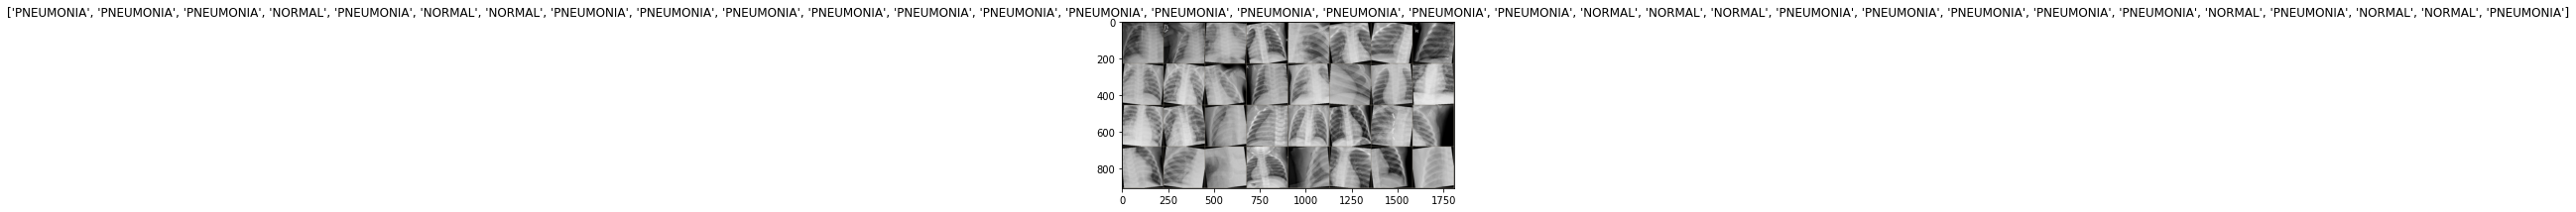

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Development

In [9]:
model_ft = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)
num_ftrs = model_ft.classifier[-1].in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() # edited CE to BCE, since there are only two classes

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# model summary
summary(model_ft, (dataloader_cfg['batch_size'], 3, 224, 224), depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [32, 2]                   --
├─Sequential: 1-1                                  [32, 960, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [32, 16, 112, 112]        464
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        464
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          3,440
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          4,440
│    └─InvertedResidual: 2-5                       [32, 40, 28, 28]          10,328
│    └─InvertedResidual: 2-6                       [32, 40, 28, 28]          20,992
│    └─InvertedResidual: 2-7                       [32, 40, 28, 28]          20,992
│    └─InvertedResidual: 2-8                       [32, 80, 14, 14]          32,080
│    └─InvertedResidual: 2-9                       [32, 80, 14, 14]          34,760
│    └─

# Model Training

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("save model")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
%%time
# will save best model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 163/163 [00:44<00:00,  3.66it/s]


train Loss: 0.2422 Acc: 0.9024


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


val Loss: 1.1715 Acc: 0.7308
save model

Epoch 1/9
----------


100%|██████████| 163/163 [00:44<00:00,  3.70it/s]


train Loss: 0.1758 Acc: 0.9350


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


val Loss: 0.1917 Acc: 0.9359
save model

Epoch 2/9
----------


100%|██████████| 163/163 [00:44<00:00,  3.67it/s]


train Loss: 0.1634 Acc: 0.9325


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


val Loss: 0.2977 Acc: 0.9087

Epoch 3/9
----------


100%|██████████| 163/163 [00:45<00:00,  3.61it/s]


train Loss: 0.1585 Acc: 0.9410


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


val Loss: 0.1221 Acc: 0.9583
save model

Epoch 4/9
----------


100%|██████████| 163/163 [00:44<00:00,  3.63it/s]


train Loss: 0.1413 Acc: 0.9492


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


val Loss: 0.1777 Acc: 0.9407

Epoch 5/9
----------


100%|██████████| 163/163 [00:44<00:00,  3.67it/s]


train Loss: 0.1322 Acc: 0.9502


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


val Loss: 0.2348 Acc: 0.9407

Epoch 6/9
----------


100%|██████████| 163/163 [00:46<00:00,  3.50it/s]


train Loss: 0.1301 Acc: 0.9532


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


val Loss: 0.4412 Acc: 0.8862

Epoch 7/9
----------


100%|██████████| 163/163 [00:46<00:00,  3.51it/s]


train Loss: 0.1142 Acc: 0.9557


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


val Loss: 0.2207 Acc: 0.9135

Epoch 8/9
----------


100%|██████████| 163/163 [00:46<00:00,  3.52it/s]


train Loss: 0.1019 Acc: 0.9611


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


val Loss: 0.2262 Acc: 0.9167

Epoch 9/9
----------


100%|██████████| 163/163 [00:47<00:00,  3.43it/s]


train Loss: 0.0922 Acc: 0.9668


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]

val Loss: 0.2297 Acc: 0.9231

Training complete in 8m 37s
Best val Acc: 0.958333
CPU times: user 2min 51s, sys: 19.2 s, total: 3min 10s
Wall time: 8min 36s


## Saving Model Weights

In [13]:
PATH = 'drive/MyDrive/Pneumonia Classification/mobilenetv3_best_weights.pth'
torch.save(model_ft.to('cpu').state_dict(), PATH)

## Loaded Model

In [14]:
# reproducible code to intialise model
def load_model(weights_path):
    model_ft = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)
    num_ftrs = model_ft.classifier[-1].in_features
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.classifier[-1] = nn.Linear(num_ftrs, 2)
    model_ft.load_state_dict(torch.load(weights_path))
    return model_ft

loaded_model = load_model(PATH)
summary(loaded_model, [1, 3, 224, 224], depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           4,440
│    └─InvertedResidual: 2-5                       [1, 40, 28, 28]           10,328
│    └─InvertedResidual: 2-6                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-7                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-8                       [1, 80, 14, 14]           32,080
│    └─InvertedResidual: 2-9                       [1, 80, 14, 14]           34,760
│    └─

In [15]:
loaded_model.eval().to('cpu') # set model to evaluation mode

sample_batch, sample_classes = next(iter(dataloaders['test']))

pred = loaded_model(sample_batch)
argmax_pred = torch.argmax(pred, axis=1)
argmax_pred

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

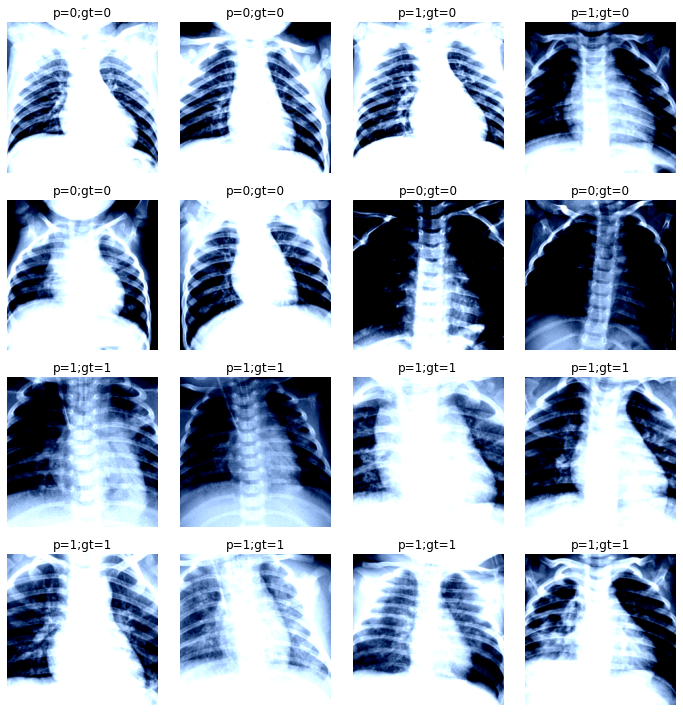

In [16]:
fig = plt.figure(tight_layout=True, figsize=(10, 10))
for idx in range(16):
    ax = fig.add_subplot(4, 4, idx+1)
    ax.imshow(sample_batch[idx].permute((1, 2, 0)))
    ax.set_title("p={};gt={}".format(argmax_pred[idx], sample_classes[idx]))
    ax.axis('off')